In [10]:
library(tidyverse)
library(umap)
library(ggsci)

library(limma)
library(edgeR)
# deseq
library(DESeq2)


## Best studies:
- PRJEB27928 (GERMANY)
- PRJEB6070  (FRANCE)
- PRJNA429097 (CHINA)   --- exclude
- PRJEB10878 (CHINA)


excluded - adenoma

# Plots

In [11]:
pca_plot <- function(df, batch_info, title, path = "", color_column = "condition", shape_column = "lab") {
  pca <- prcomp(t(na.omit(df)))
  # Plot PCA
  pca_df <-
    pca$x %>%
    as.data.frame() %>%
    rownames_to_column("sample") %>% 
    left_join(batch_info,  by = "sample") 
  # add % of explained variance
  var_expl <- pca$sdev^2 / sum(pca$sdev^2)
  names(var_expl) <- paste0("PC", 1:length(var_expl))

  # Add the label for the specific point
  pca_plot <- pca_df %>%
    ggplot(aes_string("PC1", "PC2", color = color_column)) +
    geom_point(aes_string(col=color_column, shape=shape_column), size=2) +
    stat_ellipse(type = "t", level = 0.95) + # Add ellipses for each condition+
    theme_classic() +
    labs(title = title,
         x = glue::glue("PC1 [{round(var_expl['PC1']*100, 2)}%]"),
         y = glue::glue("PC2 [{round(var_expl['PC2']*100, 2)}%]")) 


  if (path == "") {
    return(pca_plot)
  } else {
    ggsave(path, pca_plot)
  }
}


# boxplot
boxplot_plot <- function(protein_matrix, title, path = "") {
  # Reshape data into long format
  long_data <- tidyr::gather(protein_matrix, 
                             key = "sample", value = "Intensity")
  # Log tranformed scale
  boxplot <- ggplot(long_data, aes(x = sample, y = Intensity)) + 
    geom_boxplot() +
    stat_summary(fun = mean, geom = "point", shape = 4, size = 1.5, color = "red") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size = 5)) +
    labs(title = title) 

  if (path == "") {
    return(boxplot)
  } else {
    ggsave(path, boxplot)
  }
}



umap_plot <- function(df, metadata, title = "UMAP Projection", color_column = "study_accession", path = "") {
  # Perform UMAP on the transposed merged mass spectrometry data
  umap_result <- umap(t(df))
  
  # Convert the UMAP result into a data frame and merge with metadata
  umap_data <- data.frame(umap_result$layout) %>%
    rownames_to_column('sample') %>%
    # rename(sample = rowname) %>%
    left_join(metadata[, c('sample', 'country', 'class', 'study_accession', 'instrument_model', 'Study_Equip')], by = "sample") %>%
    column_to_rownames("sample")
   

  plot <- ggplot(umap_data, aes_string(x = "X1", y = "X2", color = color_column)) +
    geom_point(aes_string(col = color_column), size = 0.7) +
    stat_ellipse(type = "t", level = 0.95) + # Add ellipses for each condition
    theme_minimal() +
    scale_color_lancet() + 
    labs(title = title, x = "UMAP 1", y = "UMAP 2") +
    guides(color = guide_legend(override.aes = list(size = 3))) # Ensure legend accurately represents centroids
  
    
    if (path == "") {
        return(plot)
  } else {
        ggsave(path, plot)
  }
}


# Read data

In [12]:
metadata <- read.csv('/home/yuliya/repos/other/removeBatch/evaluation_microbiom_data/test_data/metadata_2250_CRC_cohort_20231114.tsv', sep = '\t') %>%
    filter(is.na(to_exclude)) %>%
    filter(class != "adenoma") %>%
    mutate(class = as.factor(class), country = as.factor(country)) %>%
    # keep only data from best studies list
    filter(study_accession %in% c("PRJEB27928", "PRJEB6070", "PRJEB10878")) %>%
    filter(!(study_accession == "PRJEB6070" & country == "DEU")) %>% 
    mutate(Study_Equip = paste(study_accession, instrument_model, sep = "_")) %>%
    mutate(Study_Equip = as.factor(Study_Equip), gender = as.factor(gender))
dim(metadata)
head(metadata)

[1] 296  35

sample    HQ_clean_read_count gut_mapped_read_count gut_mapped_pc
1 ERS436799 65100593            52573025              80.75660     
2 ERS436798 46551843            37536234              80.63319     
3 ERS436797 70152830            57856186              82.47164     
4 ERS436796 67896701            53790484              79.22400     
5 ERS436795 66601039            56618511              85.01145     
6 ERS436794 67639833            54773719              80.97850     
  oral_mapped_read_count oral_mapped_pc MGS low_read low_map excluded ⋯
1 52573025               80.75660       396 NA       NA      NA       ⋯
2 37536234               80.63319       337 NA       NA      NA       ⋯
3 57856186               82.47164       267 NA       NA      NA       ⋯
4 53790484               79.22400       433 NA       NA      NA       ⋯
5 56618511               85.01145       242 NA       NA      NA       ⋯
6 54773719               80.97850       274 NA       NA      NA       ⋯
  body_subsite health_status host_phenotype host_subphenotype gender age bmi
1 stool        H             NA             NA                male   74  27 
2 stool        H             NA             NA                male   66  25 
3 stool        H             NA             NA                female 64  30 
4 stool        H             NA             NA                female 72  25 
5 stool        H             NA             NA                female 62  20 
6 stool        H             NA             NA                female 67  28 
  class   to_exclude Study_Equip                  
1 healthy NA         PRJEB6070_Illumina HiSeq 2000
2 healthy NA         PRJEB6070_Illumina HiSeq 2000
3 healthy NA         PRJEB6070_Illumina HiSeq 2000
4 healthy NA         PRJEB6070_Illumina HiSeq 2000
5 healthy NA         PRJEB6070_Illumina HiSeq 2000
6 healthy NA         PRJEB6070_Illumina HiSeq 2000

In [13]:
rownames_msp <- read.csv("/home/yuliya/repos/other/removeBatch/evaluation_microbiom_data/test_data/species_signal_2250_CRC_cohort_20231115.tsv", sep = "\t")$msp_id

msp_counts <- read.csv("/home/yuliya/repos/other/removeBatch/evaluation_microbiom_data/test_data/species_signal_count_table_2250_CRC_cohort_20240123.tsv", sep = "\t")
rownames(msp_counts) <- rownames_msp
msp_counts <- msp_counts[, colnames(msp_counts) %in% metadata$sample]

dim(msp_counts)
head(msp_counts)


[1] 2537  296

ERS848618 ERS848619 ERS848620 ERS848621 ERS848622 ERS848629 ERS848630
msp_0001     0        0         0         0        0         0           0    
msp_0002     0        0         0         0        0         0           0    
msp_0003   495     1207        10      1223      478       347        2994    
msp_0004     0        0         0         0        0         0           0    
msp_0005 64027      676      2274      3606      750       680       14436    
msp_0006     0        0         0         0        0         0           0    
         ERS848631 ERS848633 ERS848635 ⋯ ERS436742 ERS436790 ERS436799
msp_0001    0        0            0    ⋯ 0             0        0     
msp_0002    0        0            0    ⋯ 0             0        0     
msp_0003   13      110         4907    ⋯ 0             0     4529     
msp_0004    0        0            0    ⋯ 0             0        0     
msp_0005 2861      707       116001    ⋯ 0         31898     6525     
msp_0006    0        0            0    ⋯ 0             0        0     
         ERS436786 ERS436735 ERS436655 ERS436769 ERS436737 ERS436776 ERS436651
msp_0001 267        0           0         0         0         0       9       
msp_0002   0        0           0         0         0         0       0       
msp_0003   0        0           0         0         8         0       0       
msp_0004   0        0           0         0         0         0       0       
msp_0005 274       37          57      6279      2704      5166      39       
msp_0006   0        0        3799         0         0         0       0

In [14]:
logmin_merged_msp <- log2(msp_counts + min(msp_counts[msp_counts > 0])/2)
dim(logmin_merged_msp)

[1] 2537  296

In [16]:
write.table(logmin_merged_msp, file = "/home/yuliya/repos/other/removeBatch/evaluation_microbiom_data/before/logmin_three_centers.tsv", sep = "\t")
write.table(metadata, file = "/home/yuliya/repos/other/removeBatch/evaluation_microbiom_data/before/metadata_three_centers.tsv", sep = "\t", row.names = FALSE)

## filter

In [11]:
more_then_n <- 1

msp_to_keep <- msp_counts %>%
    t() %>% as.data.frame() %>%
    rownames_to_column("sample") %>%
    left_join(select(metadata, c('sample', 'study_accession')), by = "sample") %>%
    column_to_rownames("sample") %>%
    group_by(study_accession) %>%
    summarise(across(everything(), ~sum(.x != 0))) %>%
    column_to_rownames("study_accession") %>%
    # transpose and convert to data frame 
    t() %>% as.data.frame() %>%
    mutate(keep = ifelse(PRJEB27928 > more_then_n & PRJEB6070 > more_then_n & PRJEB10878 > more_then_n, 1, 0)) %>%
    filter(keep == 1) %>%
    rownames_to_column("msp") %>%
    .[,'msp']

dim(msp_counts)
filtered_msp_counts <- msp_counts[rownames_msp %in% msp_to_keep, ]
dim(filtered_msp_counts)



[1] 2537  332

[1] 1010  332

In [12]:

sum(msp_counts == 0) / (nrow(msp_counts) * ncol(msp_counts))
sum(filtered_msp_counts == 0) / (nrow(filtered_msp_counts) * ncol(filtered_msp_counts))

[1] 0.8699382

[1] 0.7038739

## check data

In [13]:
logmin_merged_msp <- log2(msp_counts + min(msp_counts[msp_counts > 0])/2)

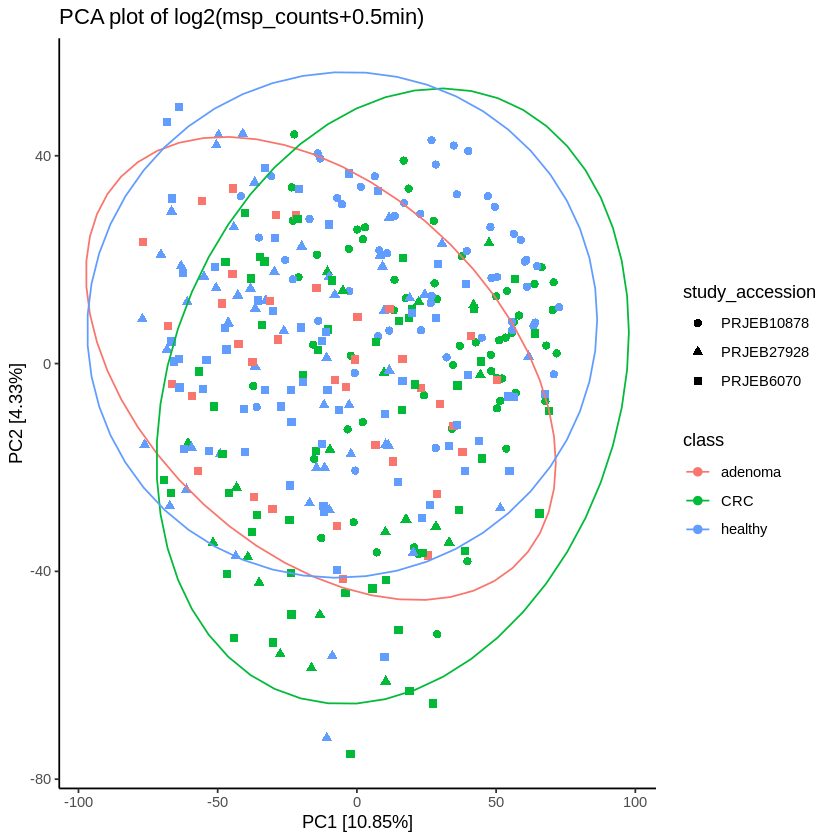

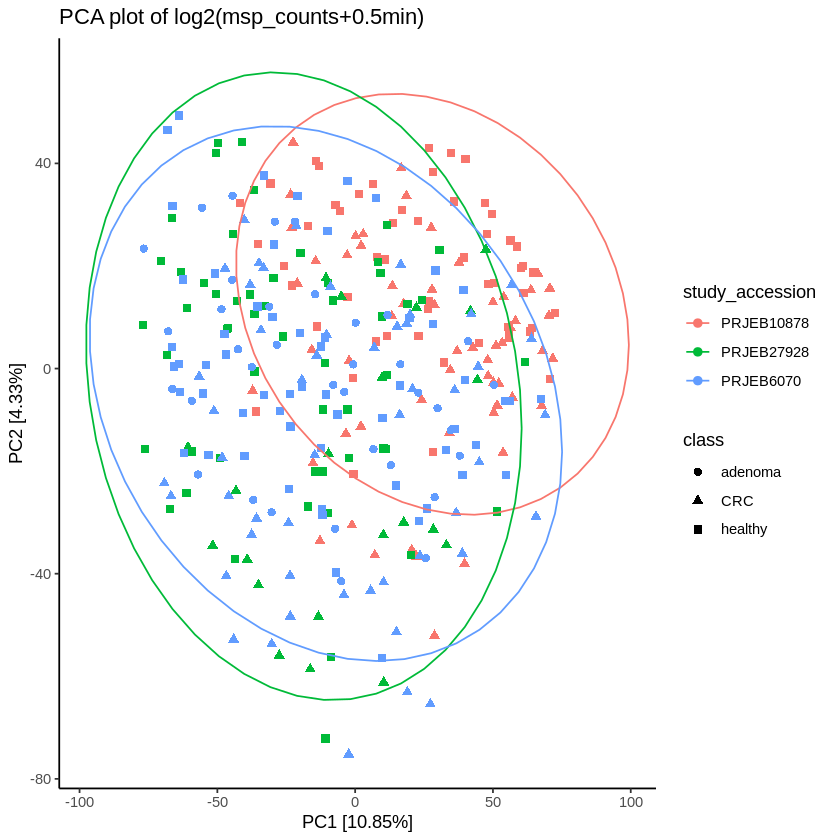

In [14]:
options(repr.plot.width = 7, repr.plot.height = 7)



pca_plot(logmin_merged_msp, metadata, 
        title = "PCA plot of log2(msp_counts+0.5min)", 
        shape_column = "study_accession", color_column = "class")

pca_plot(logmin_merged_msp, metadata, 
        title = "PCA plot of log2(msp_counts+0.5min)", 
        color_column = "study_accession", shape_column = "class")

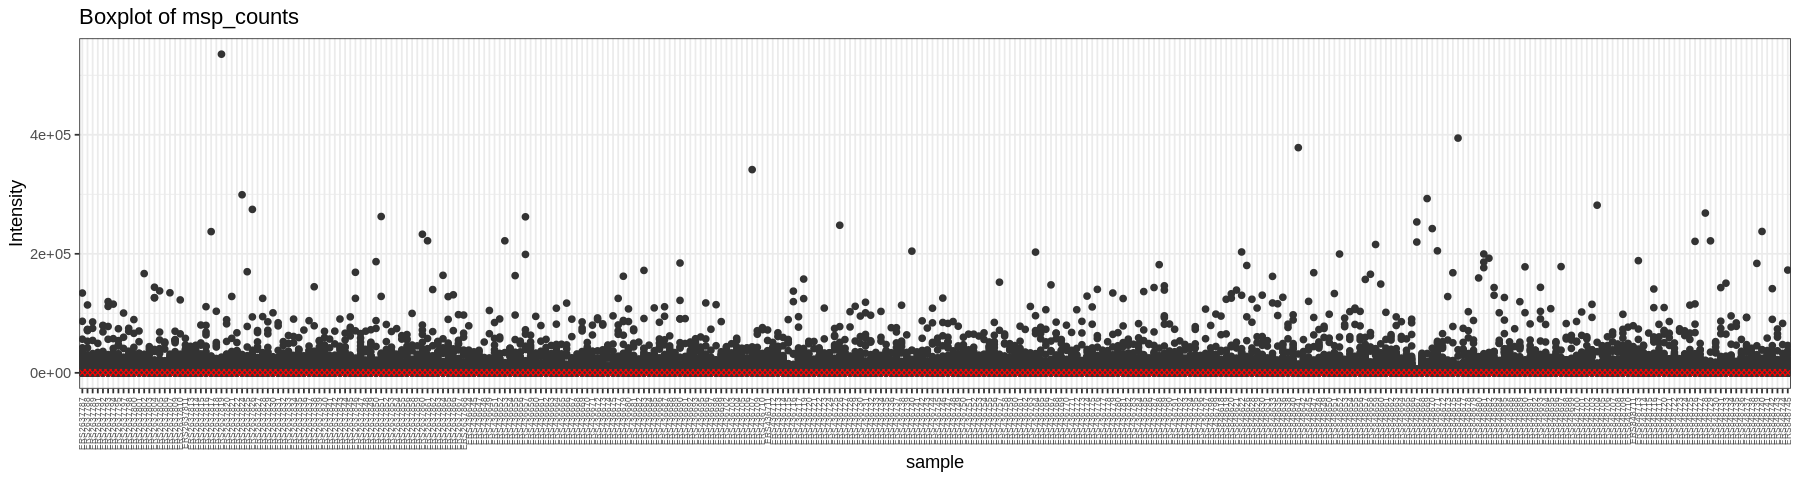

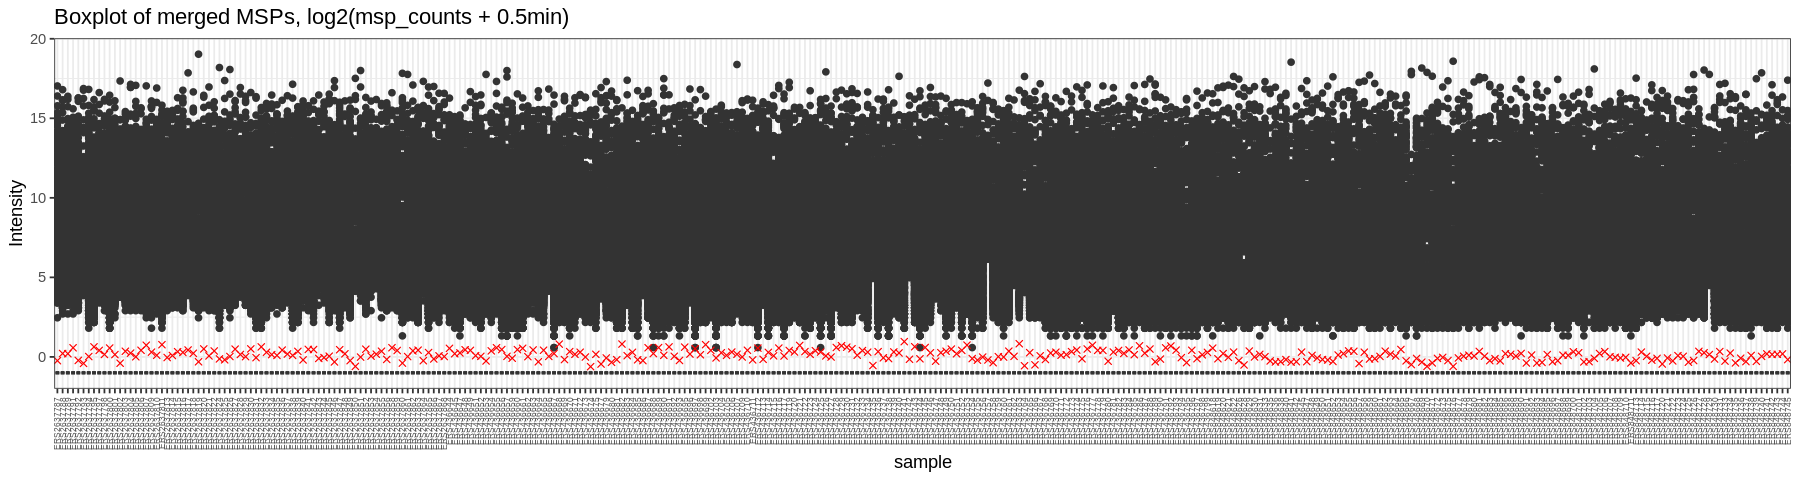

In [15]:
options(repr.plot.width = 15, repr.plot.height = 4)
boxplot_plot(msp_counts, title = "Boxplot of msp_counts")
boxplot_plot(logmin_merged_msp, title = "Boxplot of merged MSPs, log2(msp_counts + 0.5min)")

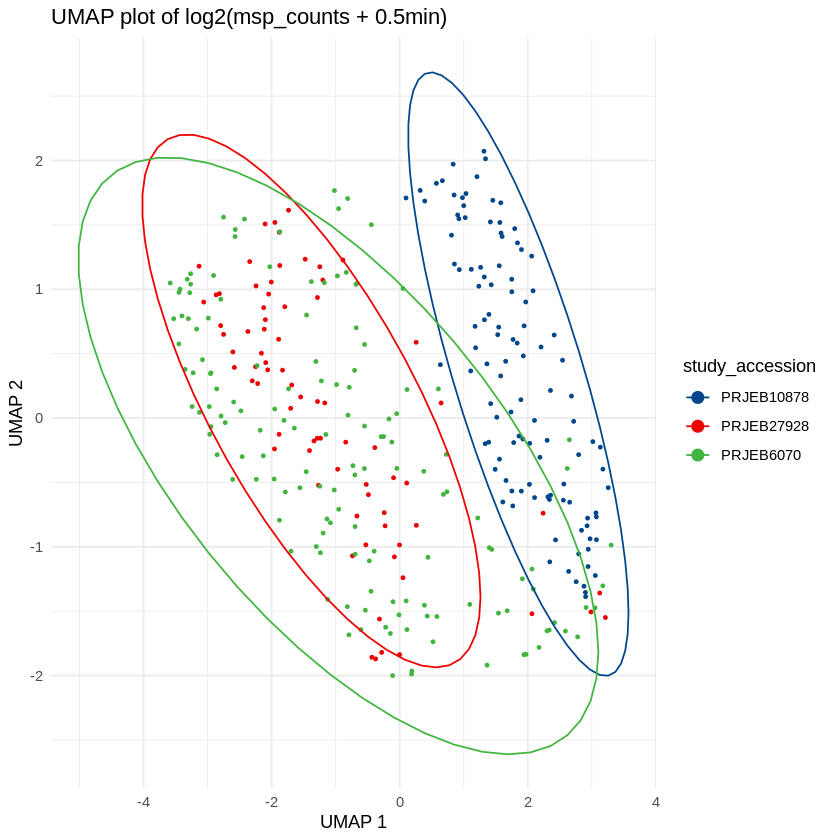

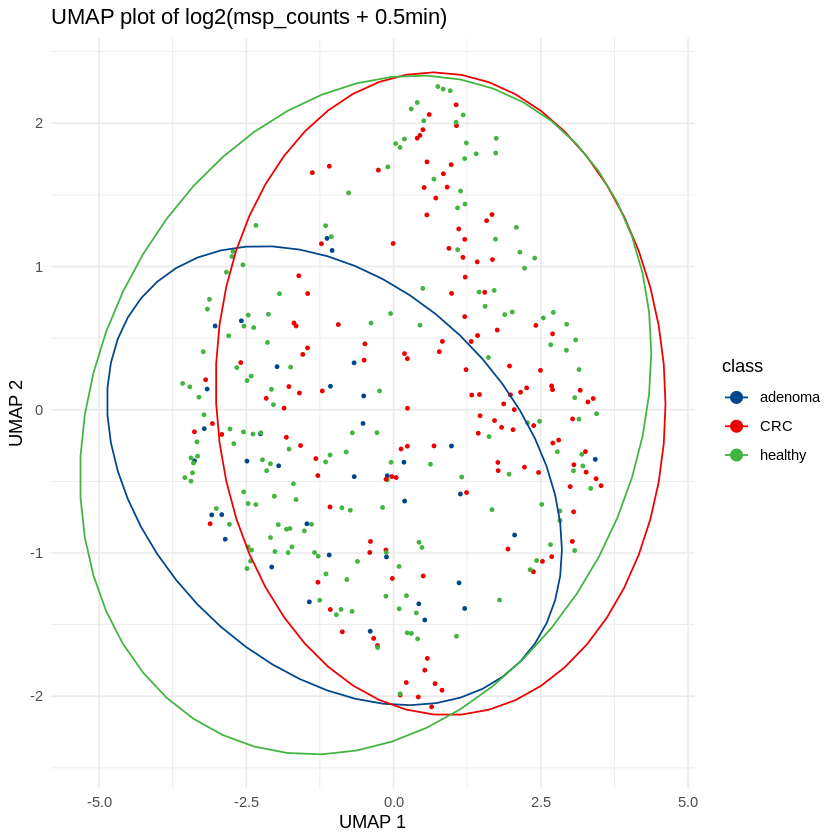

In [16]:
options(repr.plot.width = 7, repr.plot.height = 7)
umap_plot(logmin_merged_msp, metadata, title = "UMAP plot of log2(msp_counts + 0.5min)", color_column = "study_accession")
umap_plot(logmin_merged_msp, metadata, title = "UMAP plot of log2(msp_counts + 0.5min)", color_column = "class")

### filtered

In [17]:
logmin_filtered_msp <- log2(filtered_msp_counts + min(filtered_msp_counts[filtered_msp_counts > 0])/2)

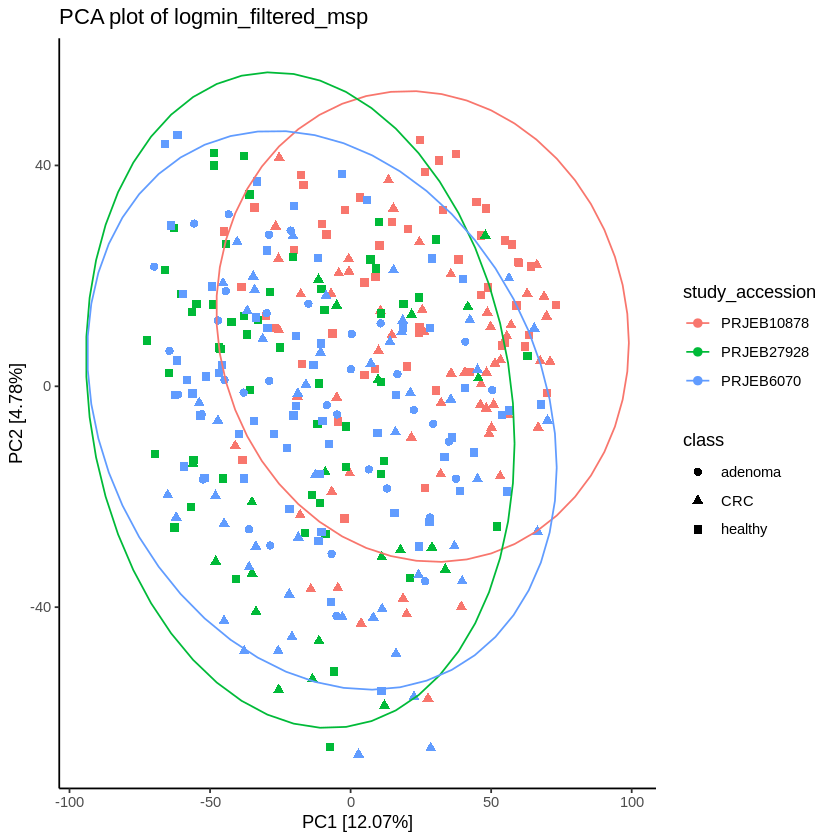

In [18]:
options(repr.plot.width = 7, repr.plot.height = 7)

pca_plot(logmin_filtered_msp, metadata, 
        title = "PCA plot of logmin_filtered_msp", 
        color_column = "study_accession", shape_column = "class")

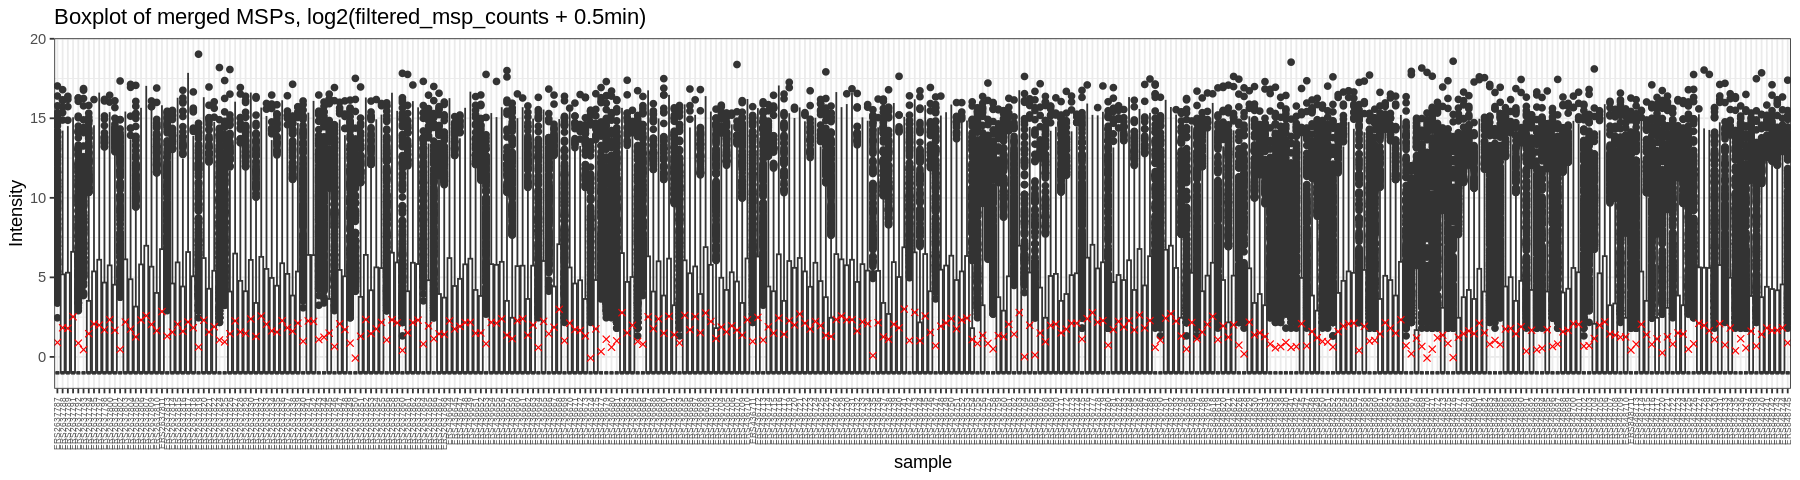

In [20]:
options(repr.plot.width = 15, repr.plot.height = 4)
boxplot_plot(logmin_filtered_msp, title = "Boxplot of merged MSPs, log2(filtered_msp_counts + 0.5min)")

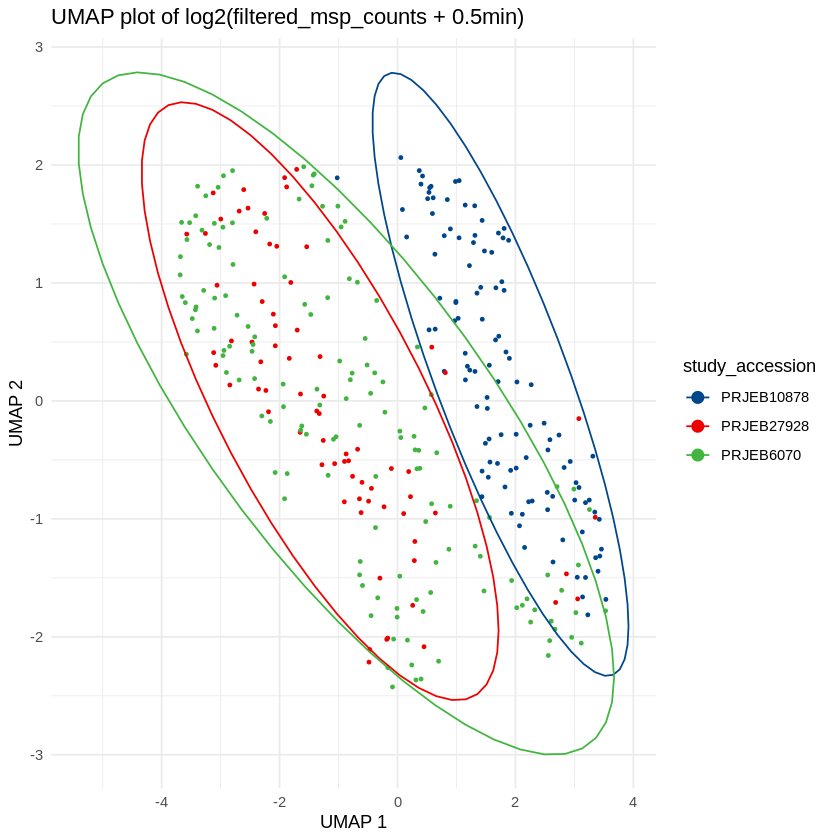

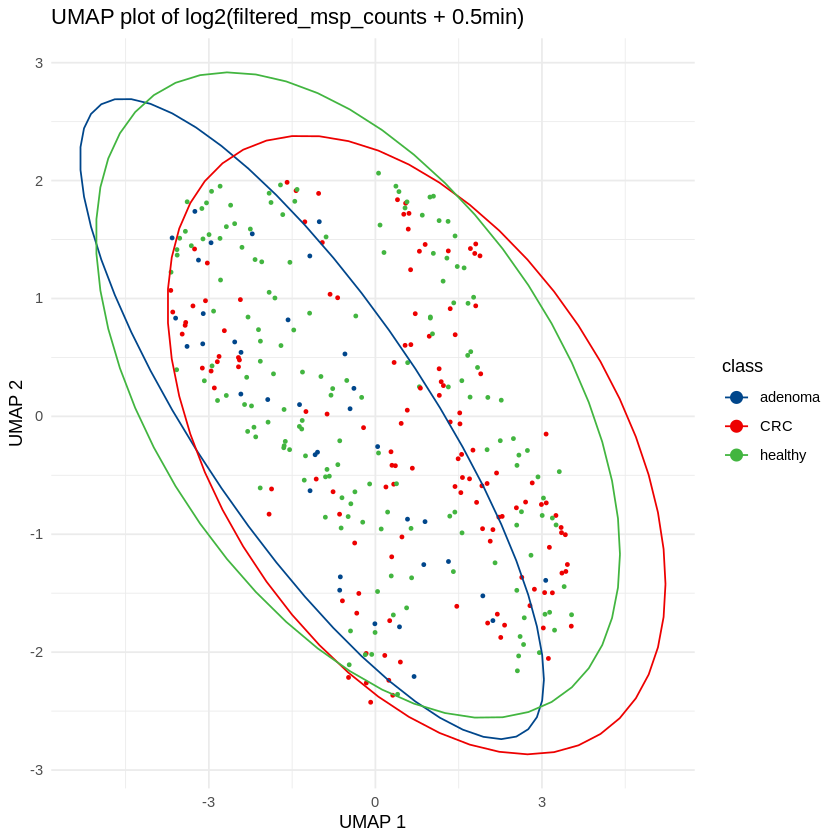

In [21]:
options(repr.plot.width = 7, repr.plot.height = 7)
umap_plot(logmin_filtered_msp, metadata, title = "UMAP plot of log2(filtered_msp_counts + 0.5min)", color_column = "study_accession")
umap_plot(logmin_filtered_msp, metadata, title = "UMAP plot of log2(filtered_msp_counts + 0.5min)", color_column = "class")

# Correction

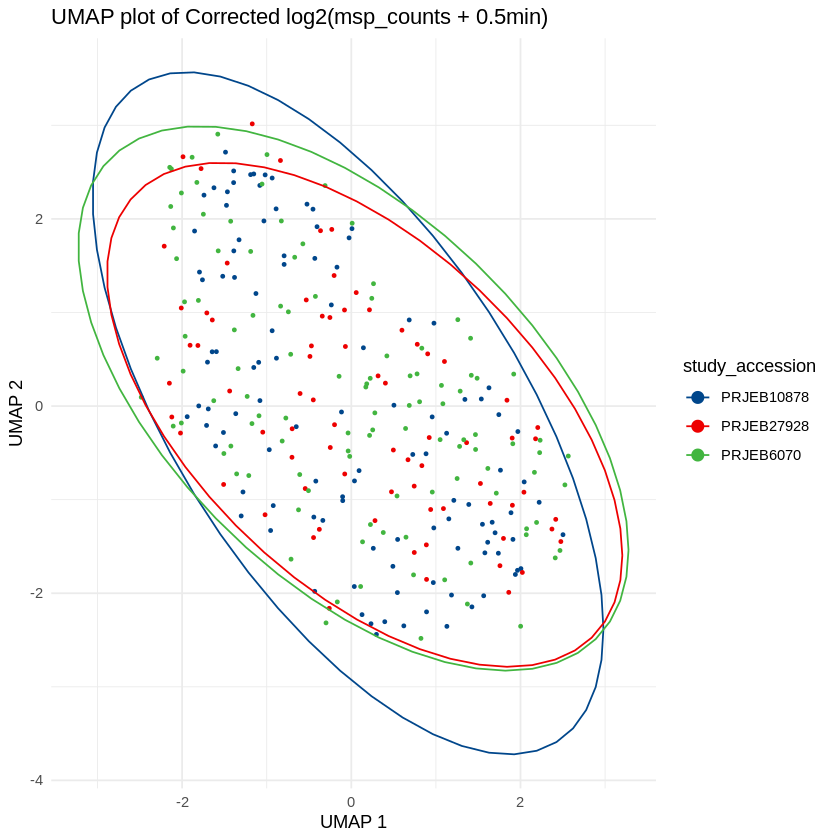

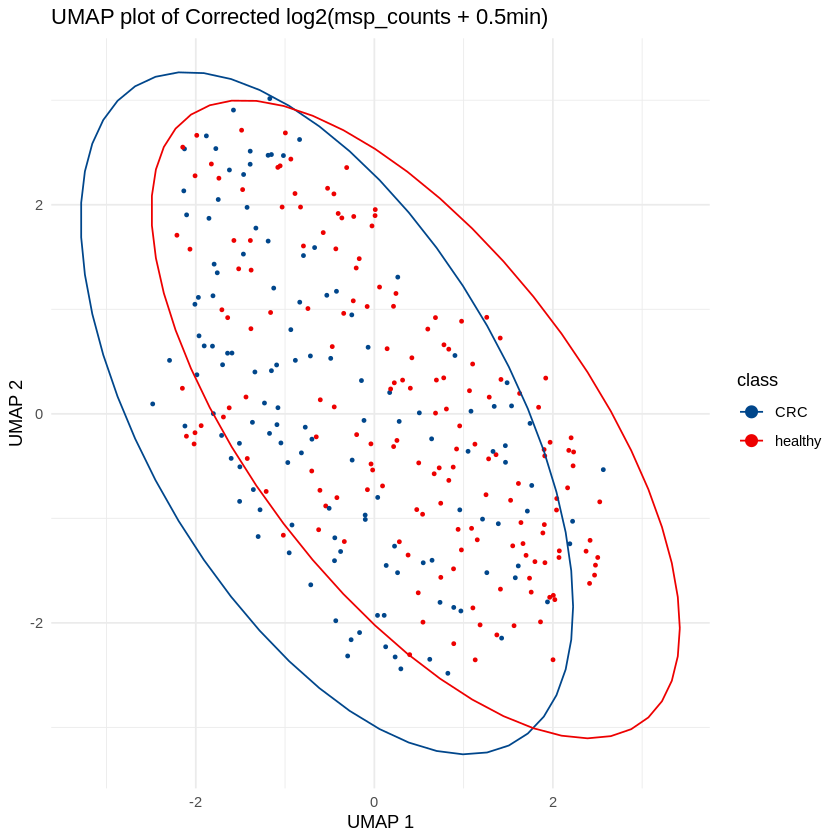

In [9]:

design= model.matrix(~class, data = metadata)
merged_msp_corrected <- removeBatchEffect(logmin_merged_msp, metadata$study_accession, design = design) %>% as.data.frame()

write.table(merged_msp_corrected, file = "/home/yuliya/repos/other/removeBatch/evaluation_microbiom_data/results/logmin_three_centers_corrected.tsv", sep = "\t")


options(repr.plot.width = 7, repr.plot.height = 7)
umap_plot(merged_msp_corrected, metadata, title = "UMAP plot of Corrected log2(msp_counts + 0.5min)", color_column = "study_accession")
umap_plot(merged_msp_corrected, metadata, title = "UMAP plot of Corrected log2(msp_counts + 0.5min)", color_column = "class")

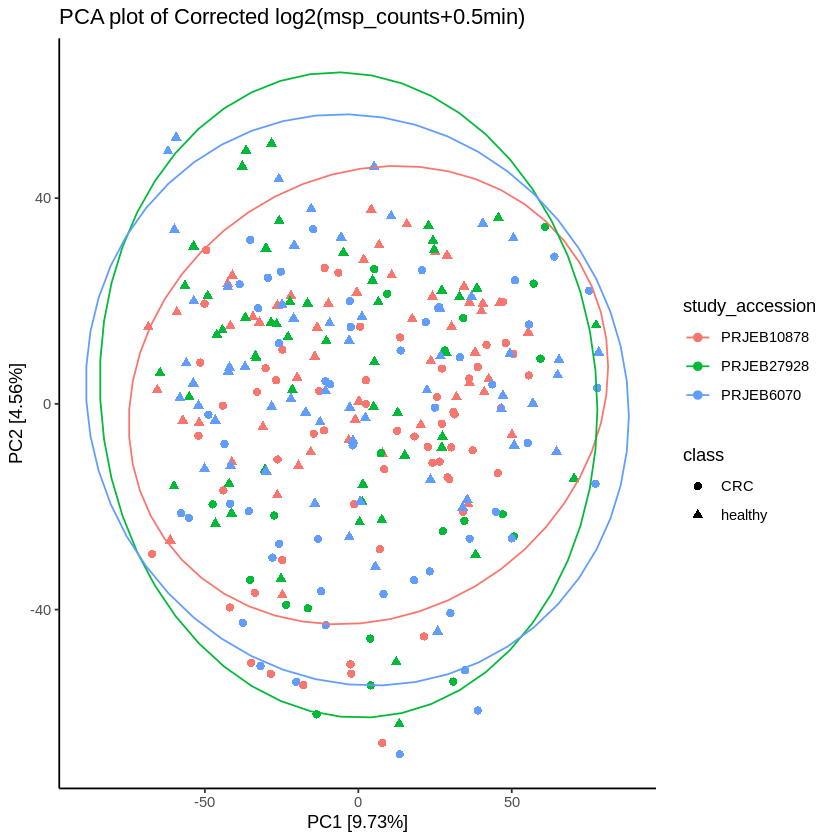

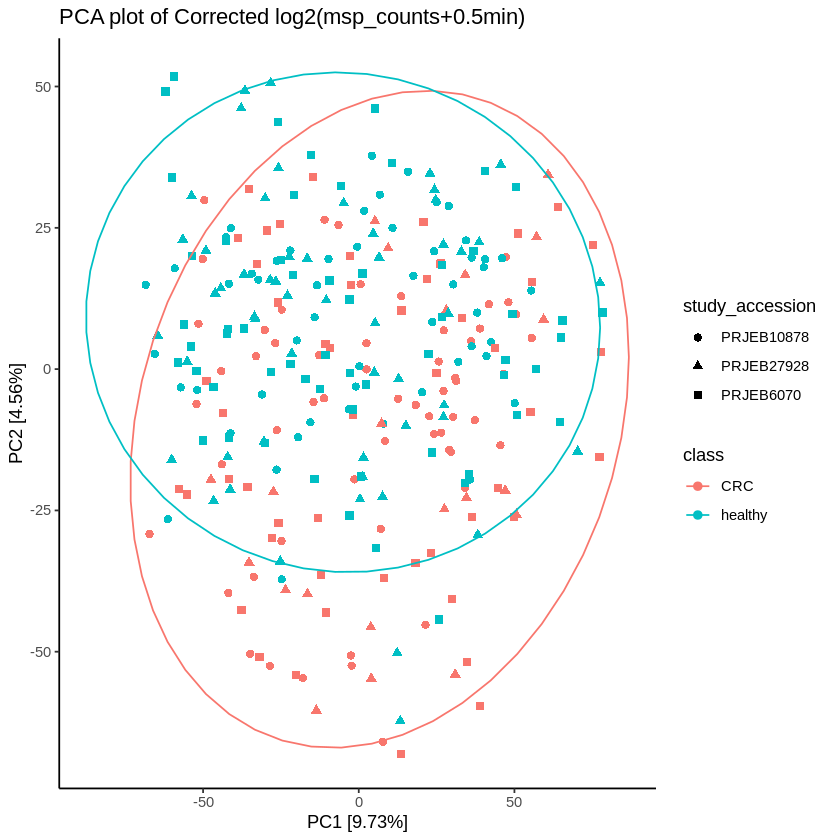

In [8]:
options(repr.plot.width = 7, repr.plot.height = 7)
pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of Corrected log2(msp_counts+0.5min)", 
        color_column = "study_accession", shape_column = "class")
        
pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of Corrected log2(msp_counts+0.5min)", 
        shape_column = "study_accession", color_column = "class")

##### Filtered

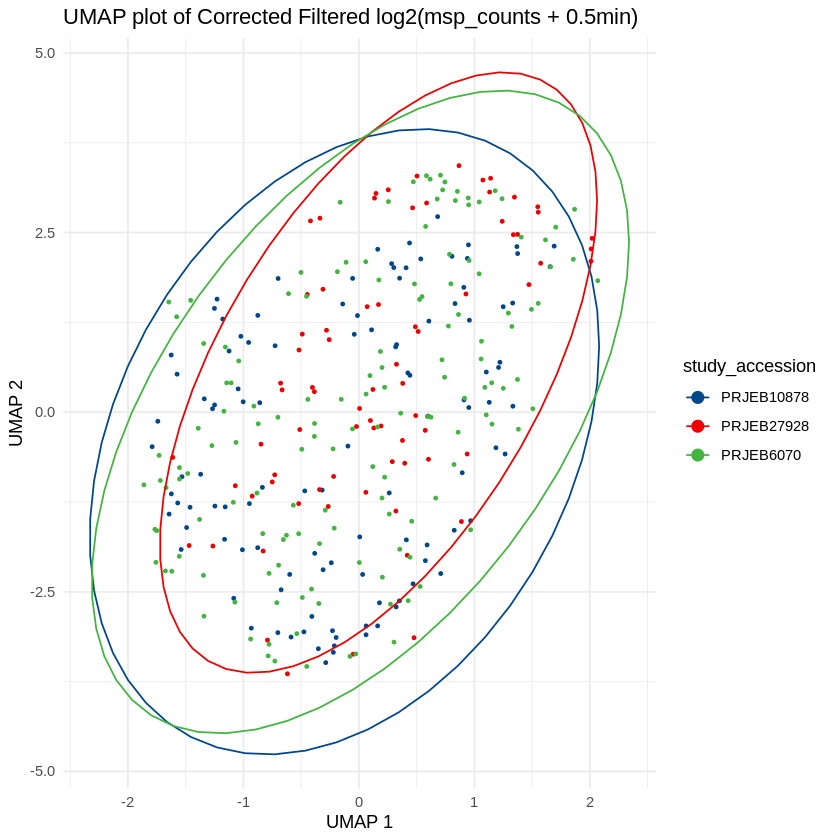

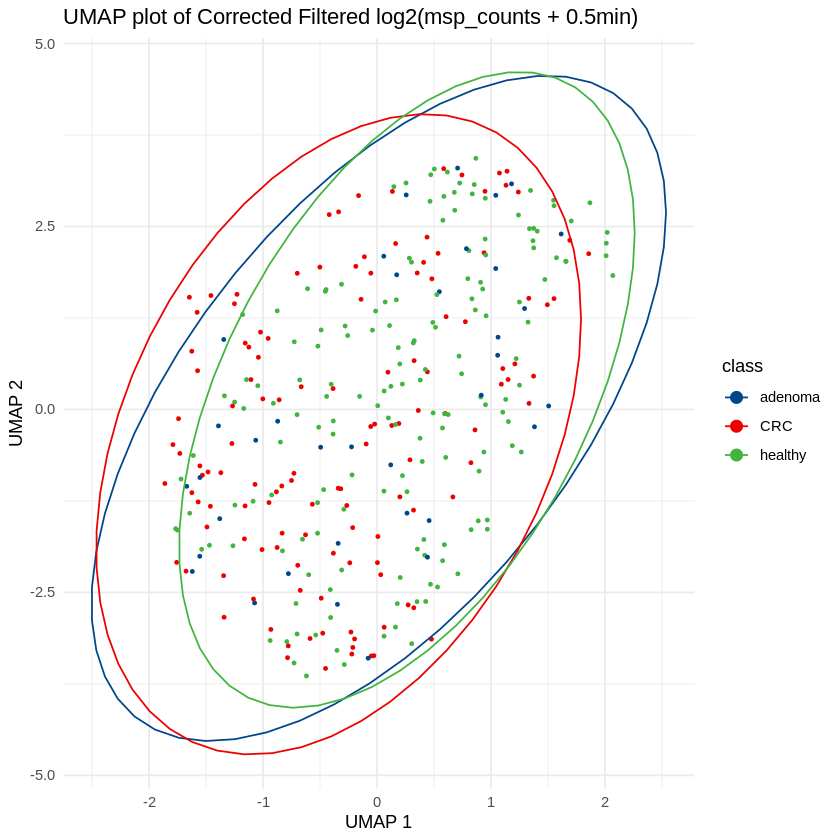

In [24]:

design= model.matrix(~class, data = metadata)
merged_msp_corrected <- removeBatchEffect(logmin_filtered_msp, metadata$study_accession, design = design) %>% as.data.frame()


options(repr.plot.width = 7, repr.plot.height = 7)
umap_plot(merged_msp_corrected, metadata, title = "UMAP plot of Corrected Filtered log2(msp_counts + 0.5min)", color_column = "study_accession")
umap_plot(merged_msp_corrected, metadata, title = "UMAP plot of Corrected Filtered log2(msp_counts + 0.5min)", color_column = "class")

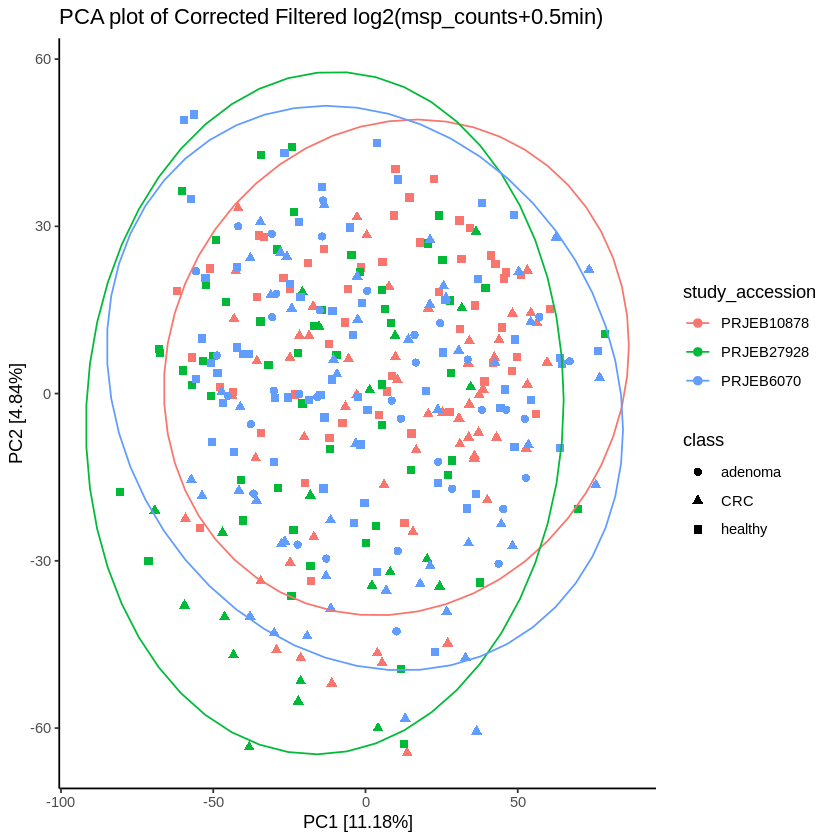

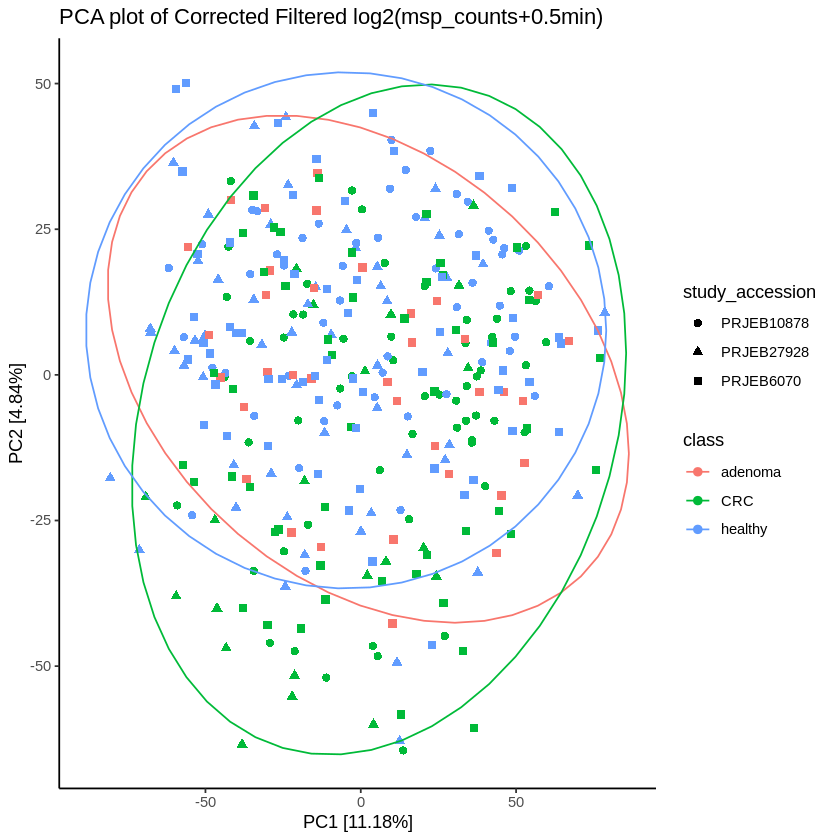

In [25]:
options(repr.plot.width = 7, repr.plot.height = 7)
pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of Corrected Filtered log2(msp_counts+0.5min)", 
        color_column = "study_accession", shape_column = "class")
        
pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of Corrected Filtered log2(msp_counts+0.5min)", 
        shape_column = "study_accession", color_column = "class")

# NOT UPDATED

# Normalization + correction

In [32]:

all_dge <- DGEList(counts=msp_counts)
all_dge$samples$group <- metadata$class
dds <- DESeqDataSetFromMatrix(countData = all_dge$counts, colData = metadata, design = ~ class)
dds <- estimateSizeFactors(dds)
normalized_counts <- as.data.frame(counts(dds, normalized=TRUE))

factor levels were dropped which had no samples



In [33]:
logmin_merged_msp <- log2(normalized_counts + min(normalized_counts[normalized_counts > 0])/2)

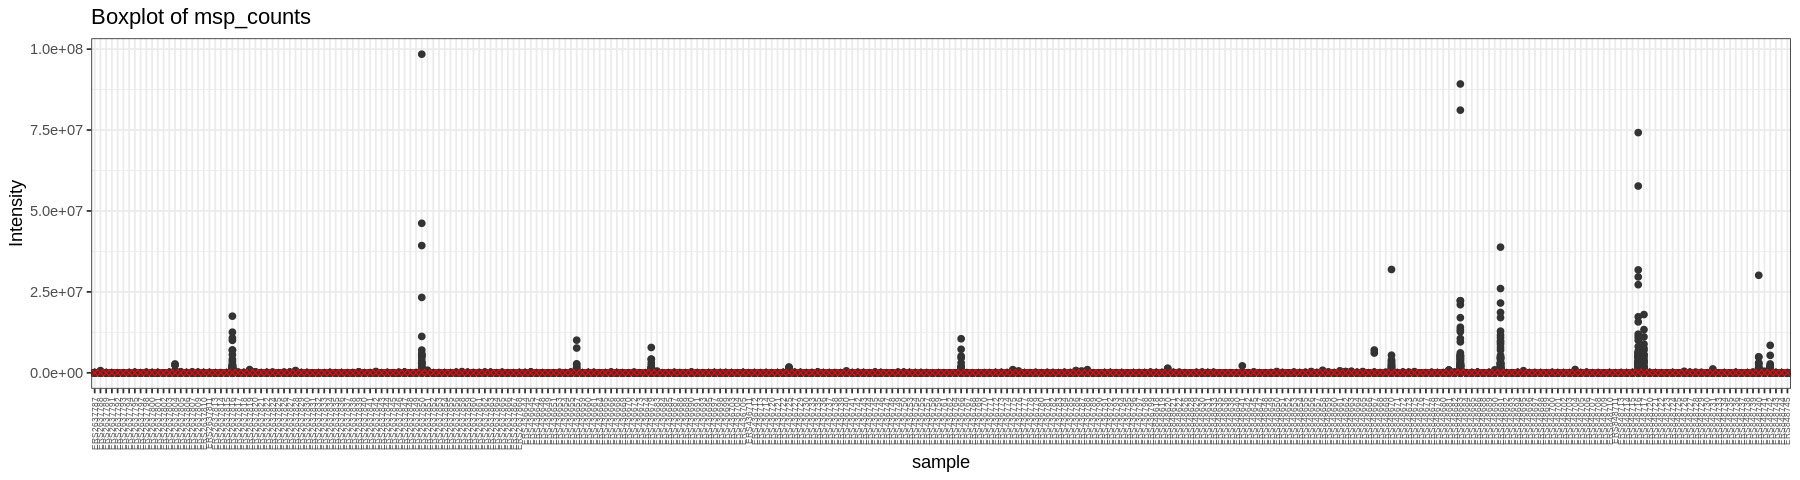

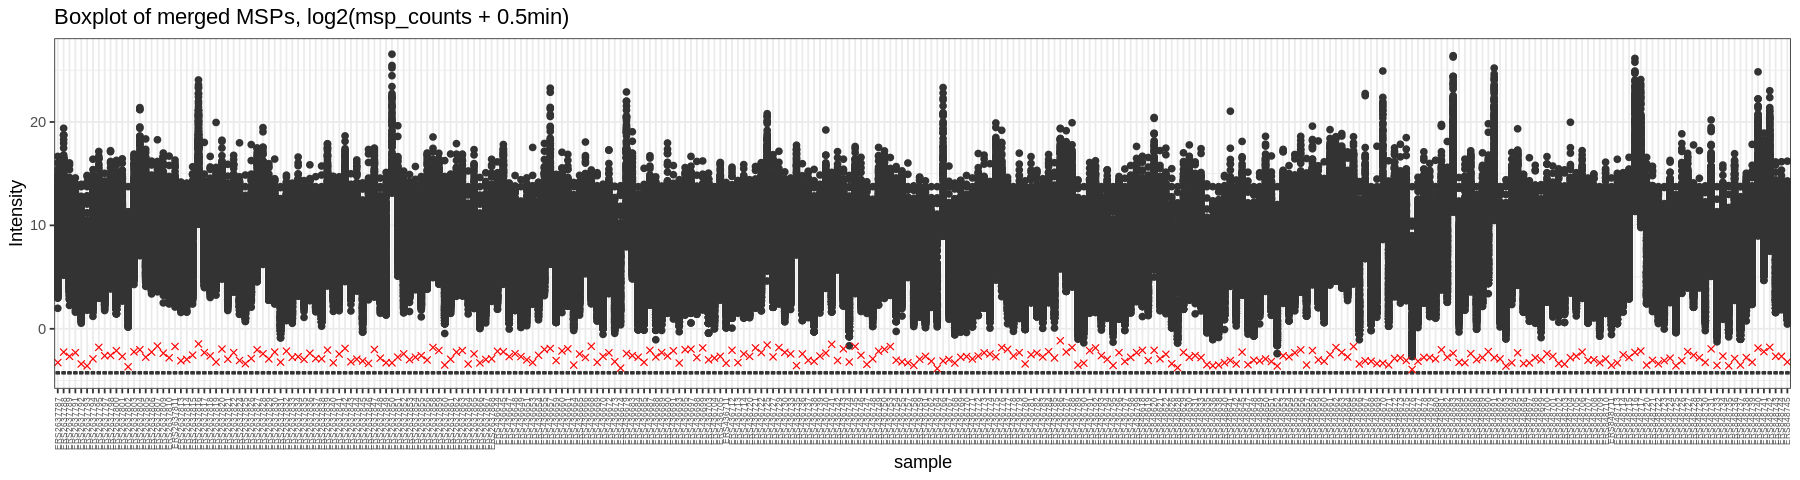

In [34]:
options(repr.plot.width = 15, repr.plot.height = 4)
boxplot_plot(normalized_counts, title = "Boxplot of msp_counts")
boxplot_plot(logmin_merged_msp, title = "Boxplot of merged MSPs, log2(msp_counts + 0.5min)")

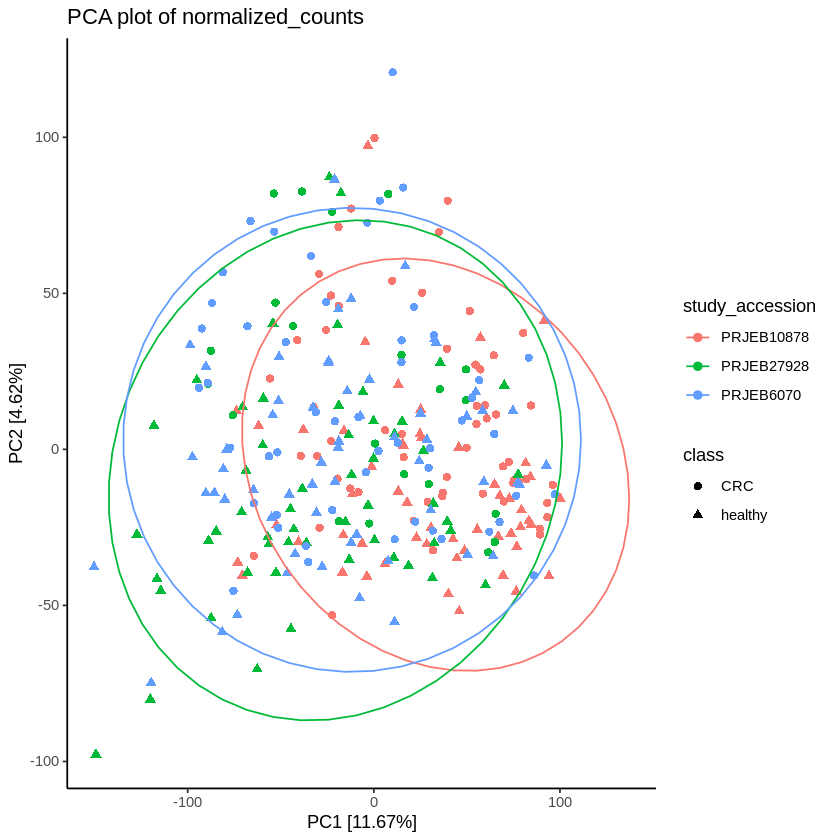

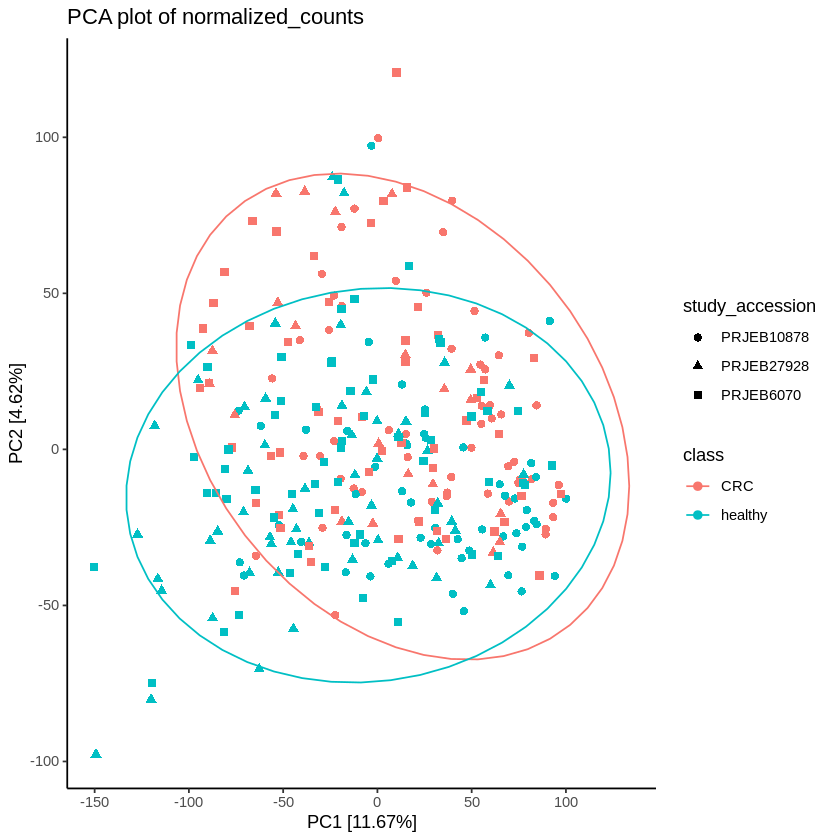

In [35]:
options(repr.plot.width = 7, repr.plot.height = 7)        
               
pca_plot(logmin_merged_msp, metadata, 
        title = "PCA plot of normalized_counts", 
        color_column = "study_accession", shape_column = "class")

pca_plot(logmin_merged_msp, metadata, 
        title = "PCA plot of normalized_counts", 
        shape_column = "study_accession", color_column = "class")

### correctiom

Coefficients not estimable: classhealthy 


Warning message:
“Partial NA coefficients for 2537 probe(s)”


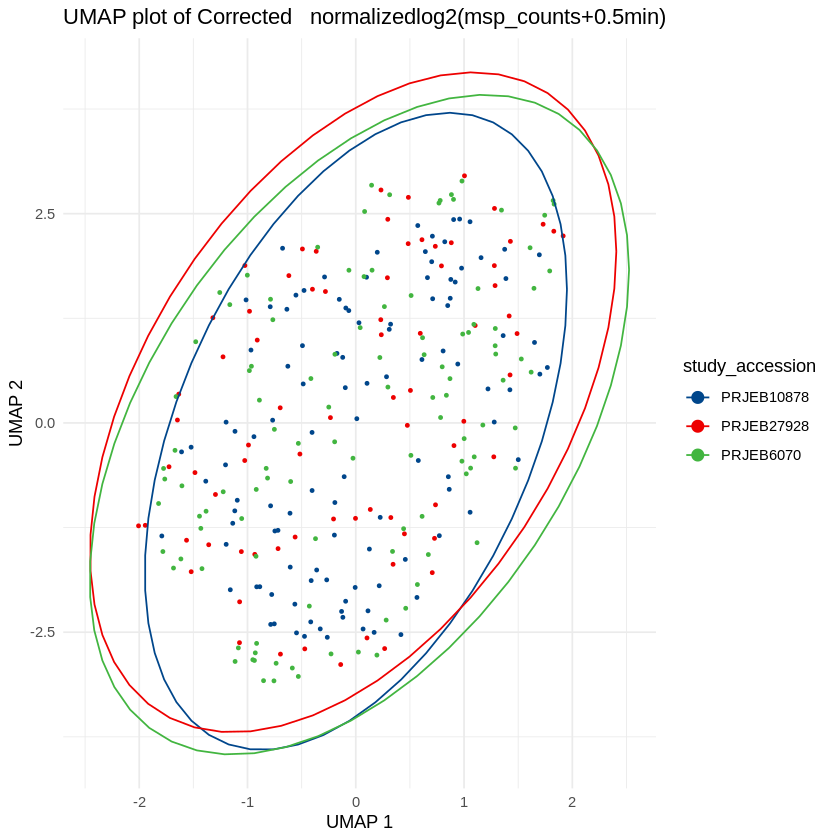

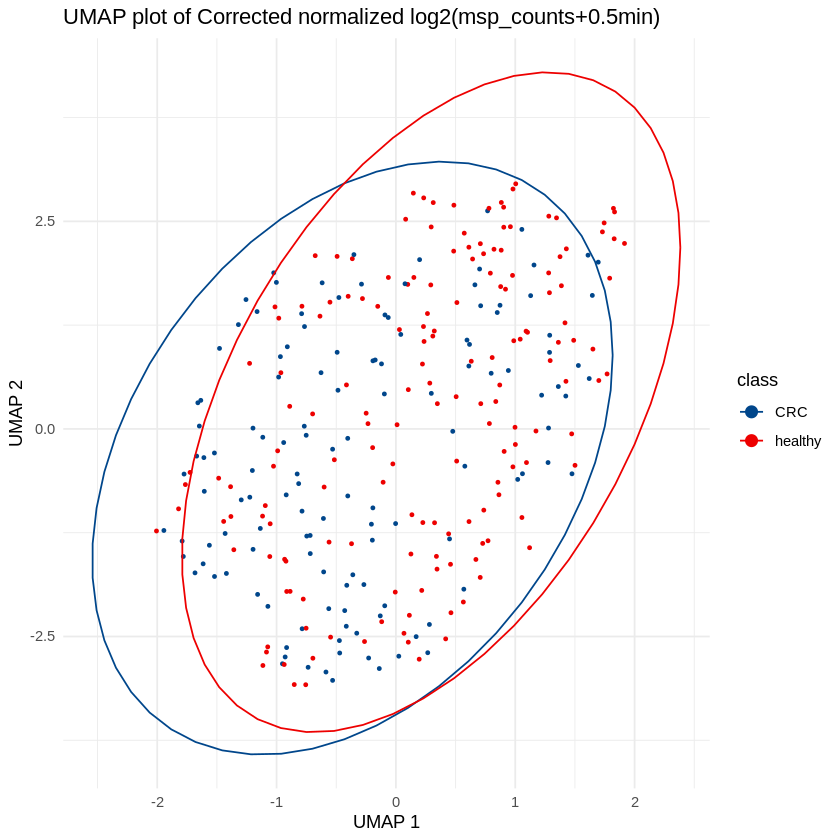

In [36]:

design= model.matrix(~class, data = metadata)
merged_msp_corrected <- removeBatchEffect(logmin_merged_msp, metadata$study_accession, design = design) %>% as.data.frame()


options(repr.plot.width = 7, repr.plot.height = 7)
# umap_plot(log2(normalized_counts+1), metadata, title = "UMAP plot of log2(msp_counts+1)", color_column = "study_accession")
umap_plot(merged_msp_corrected, metadata, title = "UMAP plot of Corrected normalizedlog2(msp_counts+0.5min)", color_column = "study_accession")
umap_plot(merged_msp_corrected, metadata, title = "UMAP plot of Corrected normalized log2(msp_counts+0.5min)", color_column = "class")

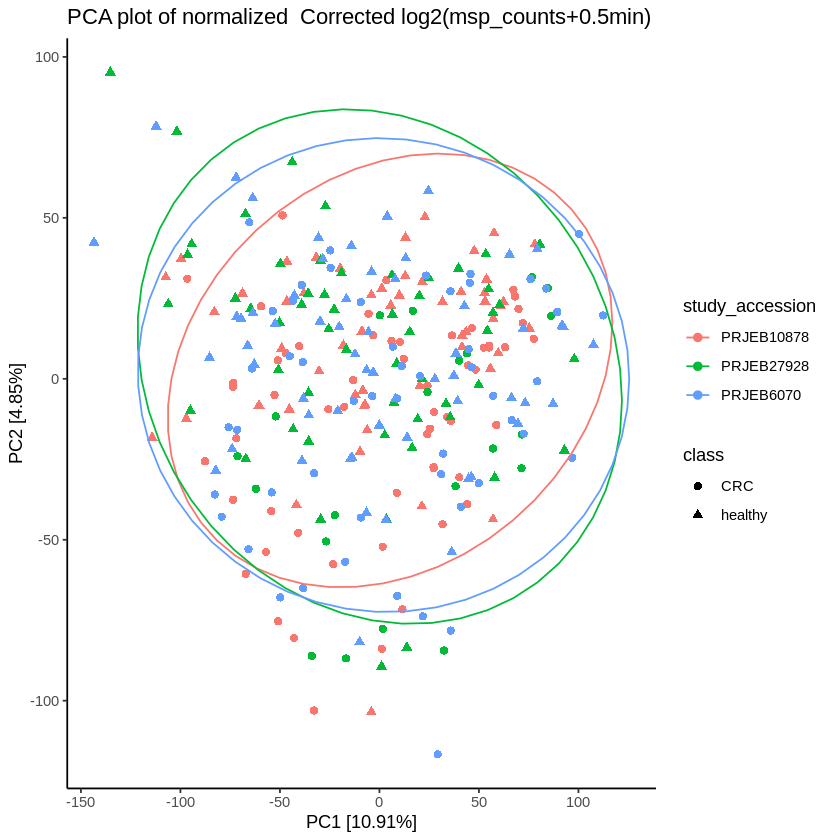

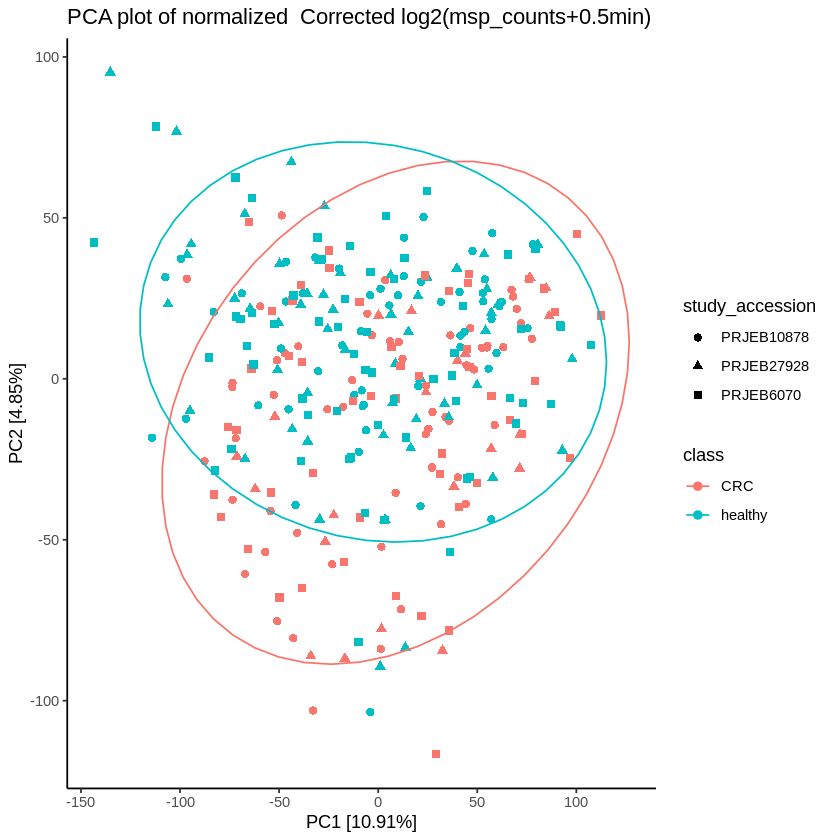

In [37]:
pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of normalized  Corrected log2(msp_counts+0.5min)", 
        color_column = "study_accession", shape_column = "class")

pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of normalized  Corrected log2(msp_counts+0.5min)", 
        shape_column = "study_accession", color_column = "class")

## Filtering normalization correction

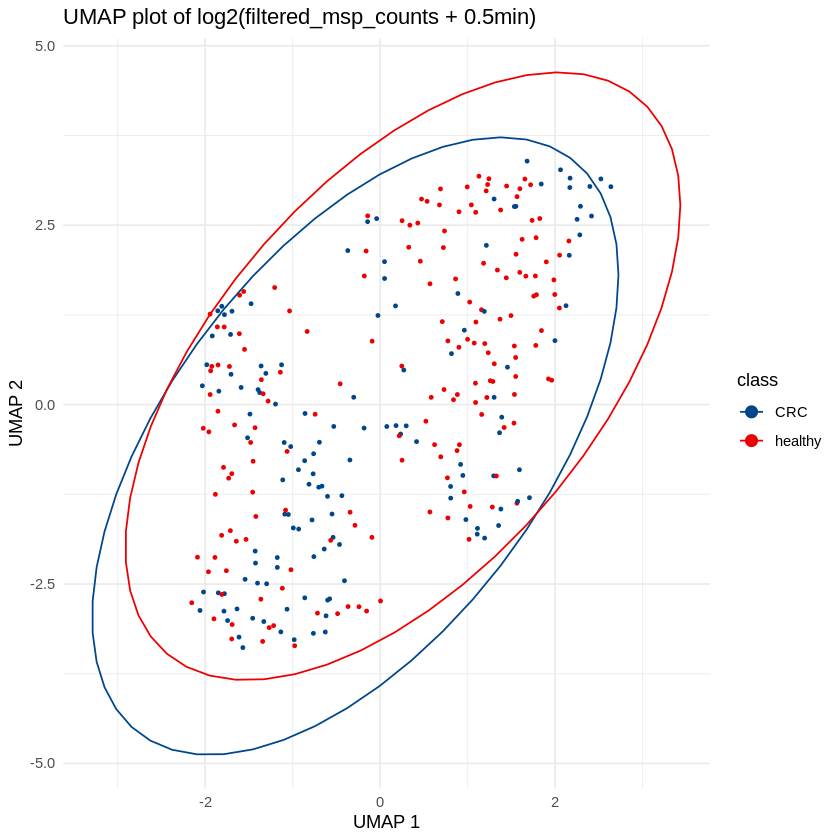

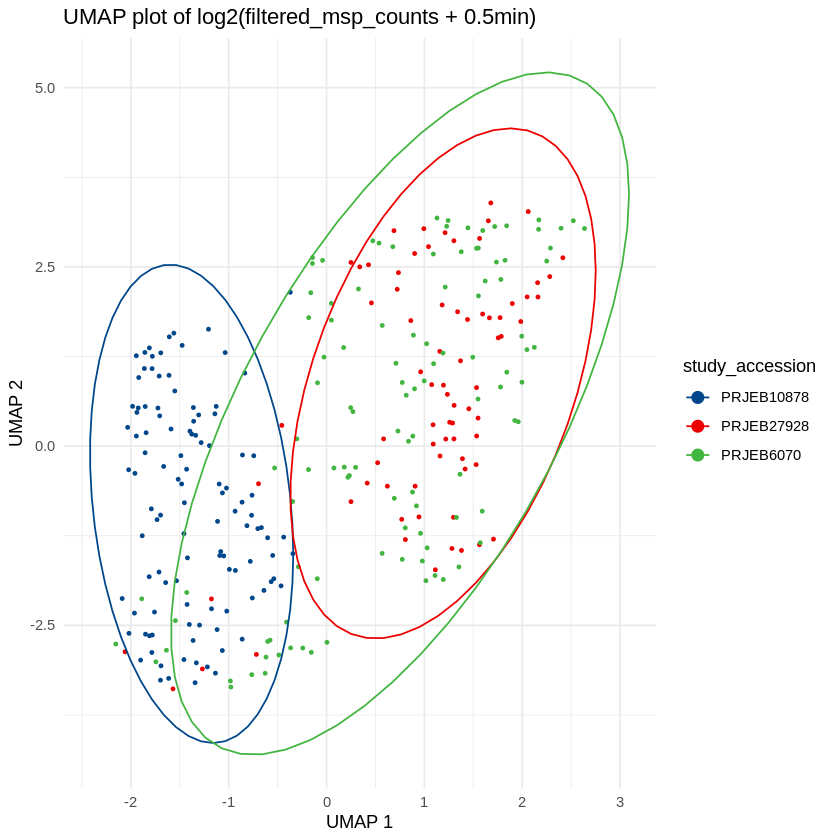

In [39]:
options(repr.plot.width = 7, repr.plot.height = 7)
umap_plot(logmin_filtered_msp, metadata, title = "UMAP plot of log2(filtered_msp_counts + 0.5min)", color_column = "class")
umap_plot(logmin_filtered_msp, metadata, title = "UMAP plot of log2(filtered_msp_counts + 0.5min)", color_column = "study_accession")

Coefficients not estimable: classhealthy 


Warning message:
“Partial NA coefficients for 1003 probe(s)”


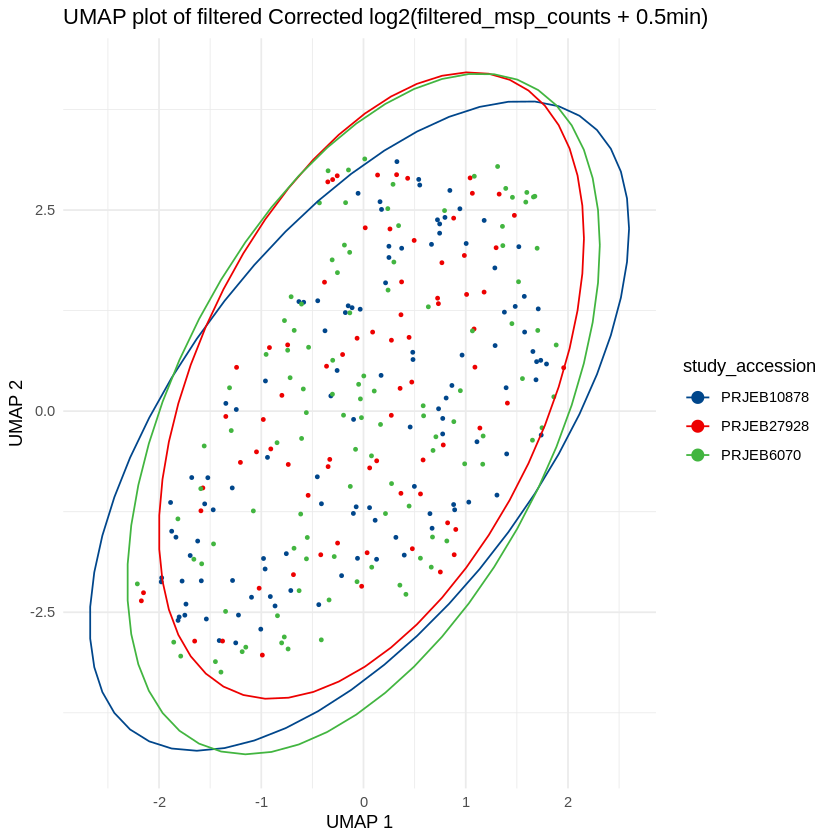

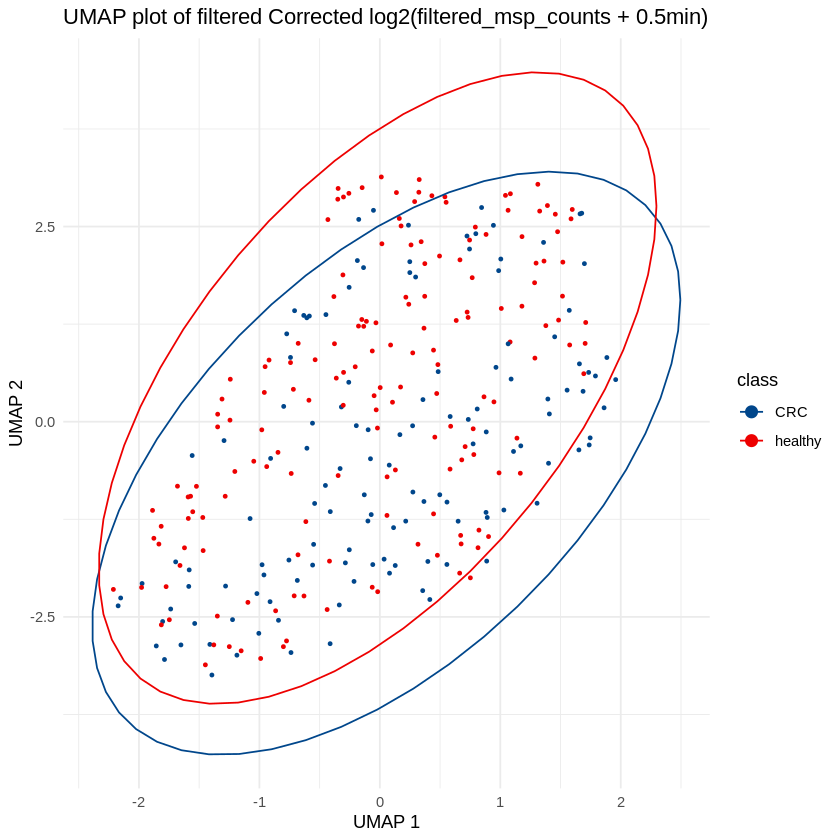

In [40]:

design= model.matrix(~class, data = metadata)
merged_msp_corrected <- removeBatchEffect(logmin_filtered_msp, metadata$study_accession, design = design) %>% as.data.frame()


options(repr.plot.width = 7, repr.plot.height = 7)
umap_plot(merged_msp_corrected, metadata, title = "UMAP plot of filtered Corrected log2(filtered_msp_counts + 0.5min)", color_column = "study_accession")
umap_plot(merged_msp_corrected, metadata, title = "UMAP plot of filtered Corrected log2(filtered_msp_counts + 0.5min)", color_column = "class")

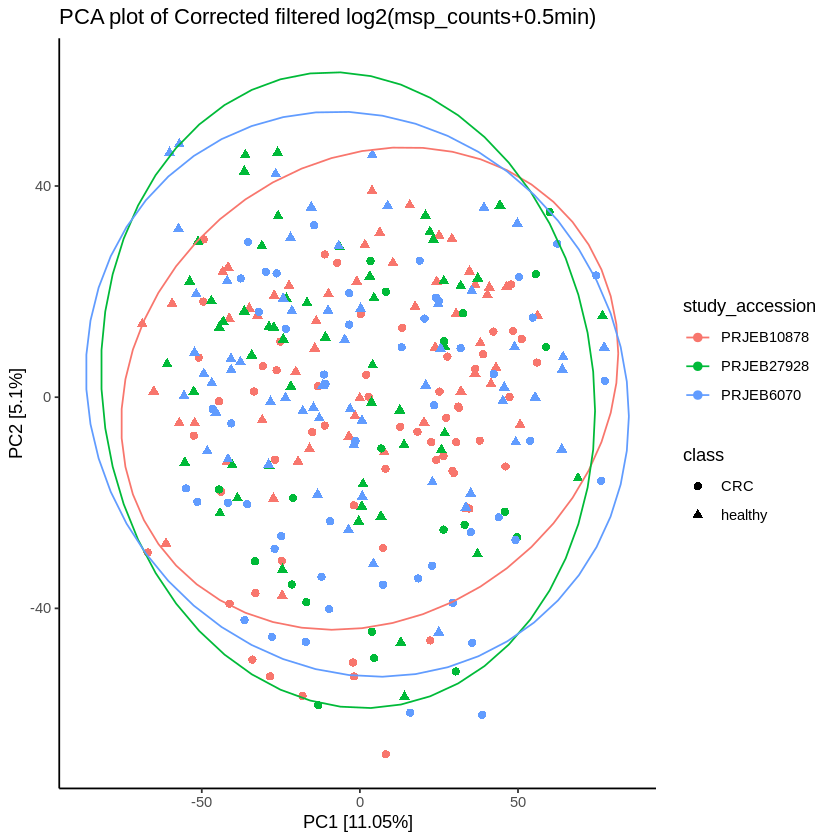

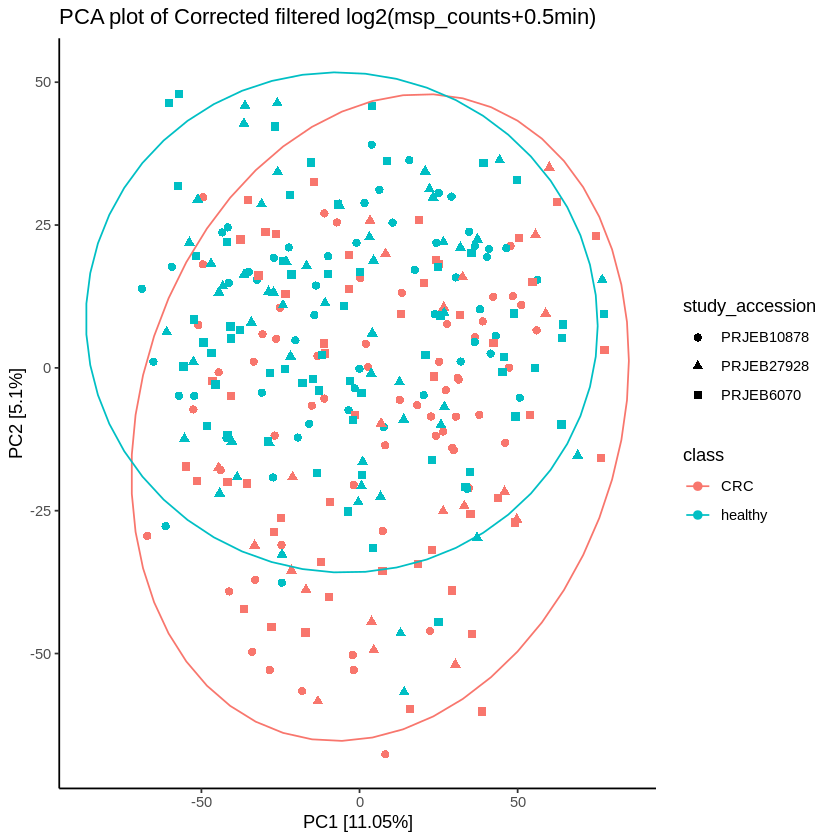

In [41]:
options(repr.plot.width = 7, repr.plot.height = 7)
pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of Corrected filtered log2(msp_counts+0.5min)", 
        color_column = "study_accession", shape_column = "class")
        
pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of Corrected filtered log2(msp_counts+0.5min)", 
        shape_column = "study_accession", color_column = "class")

normalization

In [42]:
all_dge <- DGEList(counts=filtered_msp_counts)
all_dge$samples$group <- metadata$class
dds <- DESeqDataSetFromMatrix(countData = all_dge$counts, colData = metadata, design = ~ class)
dds <- estimateSizeFactors(dds)
normalized_filtered_counts <- as.data.frame(counts(dds, normalized=TRUE))

factor levels were dropped which had no samples



In [43]:
normalized_filtered_logmin_counts <- log2(normalized_filtered_counts + min(normalized_filtered_counts[normalized_filtered_counts > 0])/2)

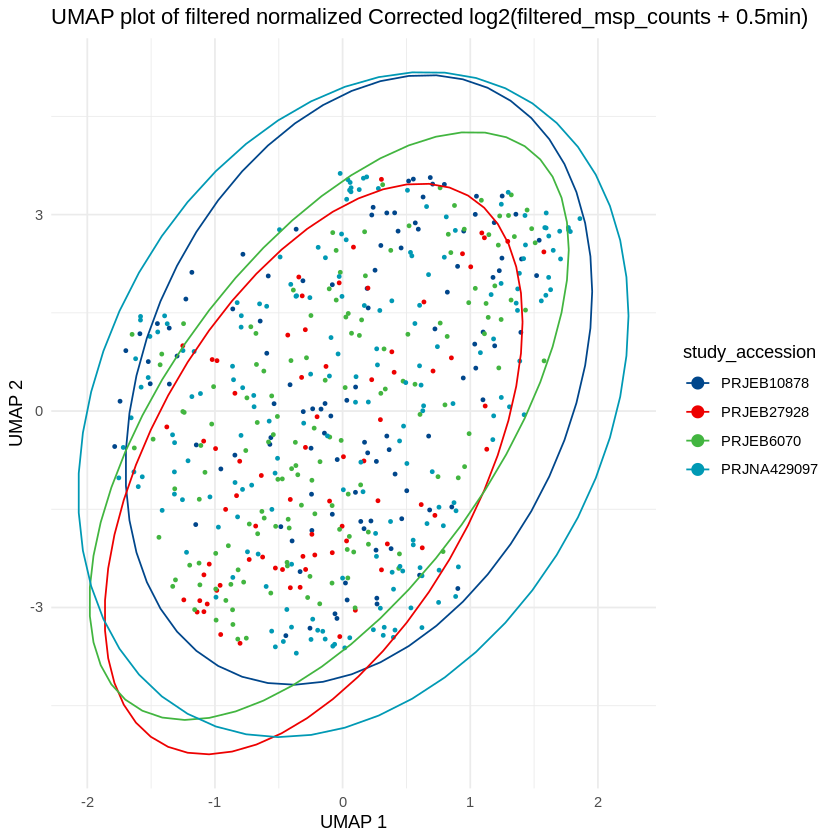

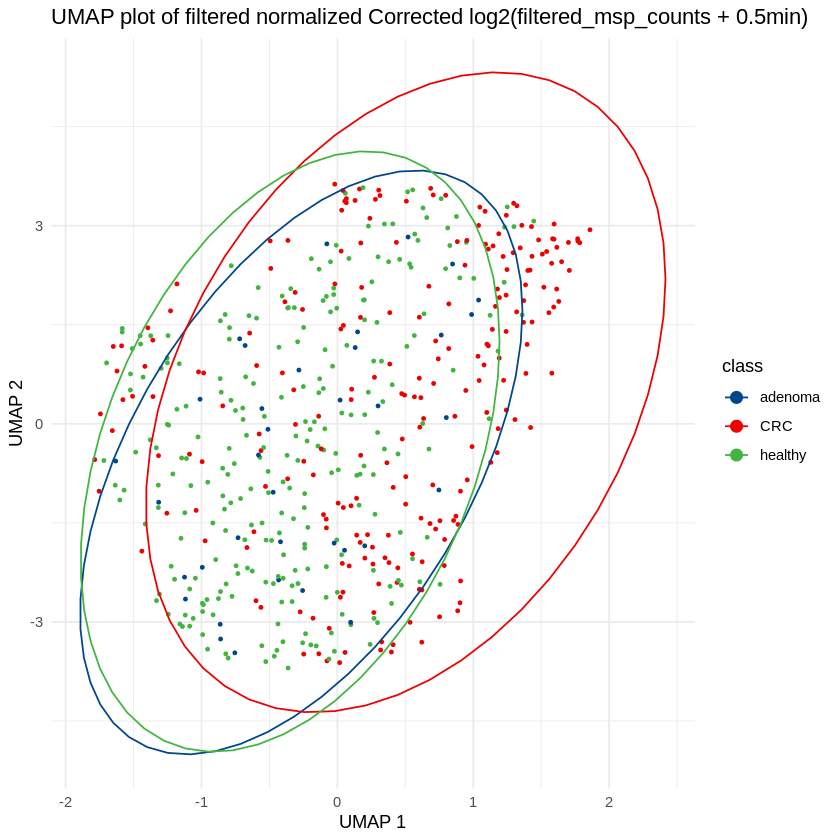

In [276]:

design= model.matrix(~class, data = metadata)
merged_msp_corrected <- removeBatchEffect(normalized_filtered_logmin_counts, metadata$study_accession, design = design) %>% as.data.frame()


options(repr.plot.width = 7, repr.plot.height = 7)
umap_plot(merged_msp_corrected, metadata, title = "UMAP plot of filtered normalized Corrected log2(filtered_msp_counts + 0.5min)", color_column = "study_accession")
umap_plot(merged_msp_corrected, metadata, title = "UMAP plot of filtered normalized Corrected log2(filtered_msp_counts + 0.5min)", color_column = "class")

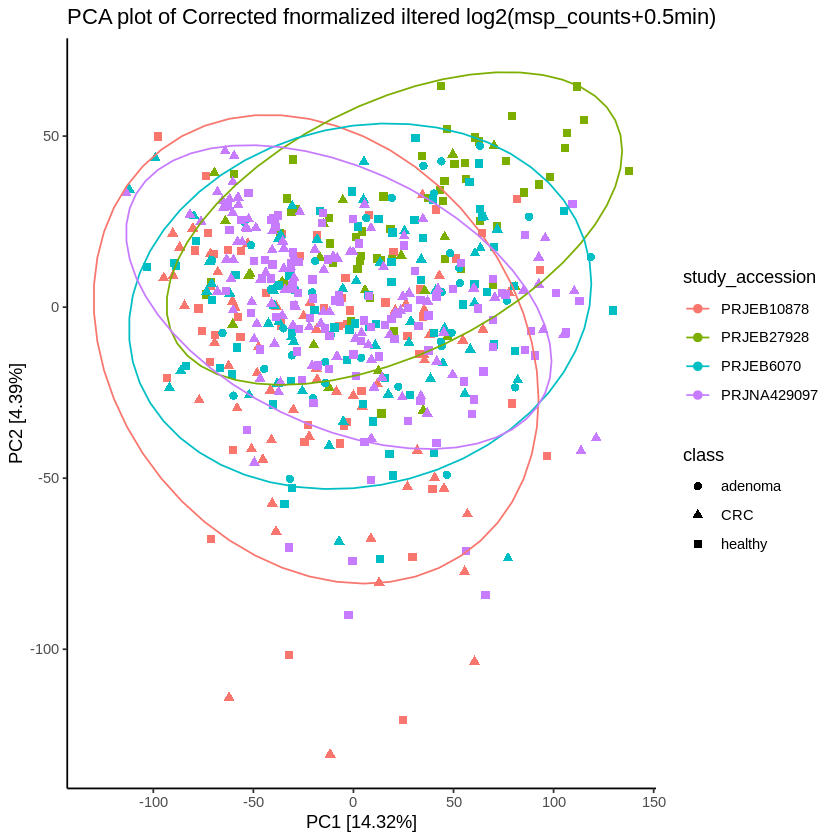

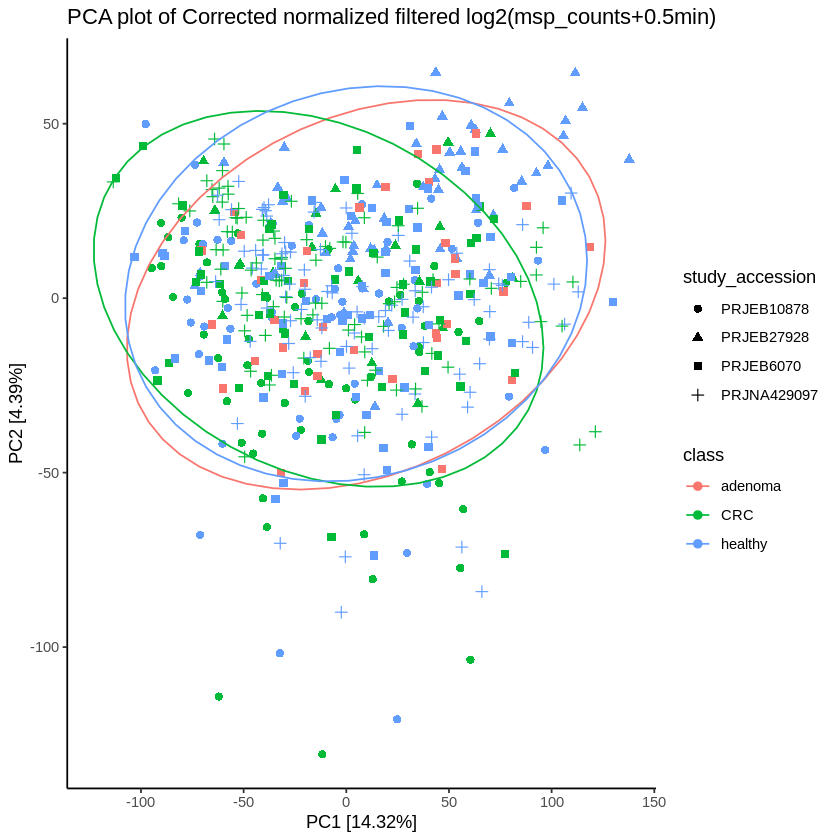

In [277]:
options(repr.plot.width = 7, repr.plot.height = 7)
pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of Corrected fnormalized iltered log2(msp_counts+0.5min)", 
        color_column = "study_accession", shape_column = "class")
        
pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of Corrected normalized filtered log2(msp_counts+0.5min)", 
        shape_column = "study_accession", color_column = "class")

# Remove NA